# Data Pre-Processing Report

## Issues:
1. Data Imbalance<br>
        1.1 Example Class 0 has ~22k images while Class 4 has 678 images [huge imbalance]
    
2. Presence of poor quality of images<br>
        2.1 Blurry images<br>
        2.2 Low contrast images<br>
        2.3 Images with low brightness<br>

## Solution tried :
1. Removing blurry images
2. Contrast and Brightness correction
3. Image data aumentation Ex Cropping, Brightness-Contrast change, log transform 
   to increase images in class which has lesser number

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.8MB/s 


# Import Data
Creating a directory data_dump where zip files of train and test will be downloaded from kaggle to google drive 
1. Download data using kaggle python package

In [0]:
!mkdir ~/.kaggle
!echo '{"username":"farha","key":"$$$$$$$$$$$$$"}' > ~/.kaggle/kaggle.json
!kaggle competitions download -c diabetic-retinopathy-detection -p data_dump

  0% 0.00/69.4k [00:00<?, ?B/s]
100% 69.4k/69.4k [00:00<00:00, 59.1MB/s]
  0% 0.00/81.6k [00:00<?, ?B/s]
100% 81.6k/81.6k [00:00<00:00, 85.0MB/s]
 48% 5.00M/10.4M [00:00<00:00, 19.5MB/s]
100% 10.4M/10.4M [00:00<00:00, 34.6MB/s]
100% 7.81G/7.81G [00:57<00:00, 110MB/s]
100% 7.81G/7.81G [00:57<00:00, 147MB/s]
100% 7.80G/7.81G [00:56<00:00, 175MB/s]
100% 7.81G/7.81G [00:57<00:00, 147MB/s]
100% 7.80G/7.81G [00:57<00:00, 166MB/s]
100% 7.81G/7.81G [00:57<00:00, 146MB/s]
100% 1.33G/1.34G [00:08<00:00, 175MB/s]
100% 1.34G/1.34G [00:08<00:00, 160MB/s]
100% 7.81G/7.81G [00:57<00:00, 180MB/s]
100% 7.81G/7.81G [00:57<00:00, 146MB/s]
100% 7.81G/7.81G [02:17<00:00, 72.7MB/s]
100% 7.81G/7.81G [02:17<00:00, 60.9MB/s]
100% 7.80G/7.81G [02:15<00:00, 60.1MB/s]
100% 7.81G/7.81G [02:15<00:00, 61.9MB/s]
100% 7.80G/7.81G [02:17<00:00, 82.2MB/s]
100% 7.81G/7.81G [02:17<00:00, 61.0MB/s]
100% 7.80G/7.81G [02:37<00:00, 51.3MB/s]
100% 7.81G/7.81G [02:37<00:00, 53.2MB/s]
100% 7.80G/7.81G [02:25<00:00, 46.5MB/s]
100

#### Using 7zip (by default in google collab) to unzip data

In [0]:
!7z x data_dump/train.zip.001
!unzip data_dump/trainLabels.csv.zip

#### Transfering test and train to tmp folder

In [0]:
!mkdir tmp
!mv train tmp

# Pre-Processing

In [1]:
#importing required libraries
import pandas as pd
import os
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import warnings
from imutils import paths
from PIL import Image
from skimage import io
from skimage import exposure

warnings.filterwarnings('ignore')
%matplotlib inline

#### Head of train label file

In [2]:
trainLabels = pd.read_csv("data/trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


#### Creating different directories for different classes of diabetic eye for classification

In [0]:
!mkdir data/train/0
!mkdir data/train/1
!mkdir data/train/2
!mkdir data/train/3
!mkdir data/train/4


In [11]:
os.path.splitext(file)[0]
trainLabels.loc[trainLabels.image==fileName, 'level'].values[0] 
base_dir + file, base_dir + str(folder_name) + "/" + file

('data/train/27510_left.jpeg', 'data/train/2/27510_left.jpeg')

#### Using trainLabels file to segregrate into different classes

In [13]:
base_dir = "data/train/"

for file in listing:
    try:
        fileName = os.path.splitext(file)[0]
        folder_name = trainLabels.loc[trainLabels.image==fileName, 'level'].values[0]  
        os.rename(base_dir + file, base_dir + str(folder_name) + "/" + file )
    except:
        print("error")
        pass

#### For verification checking files in class 0 ~ 25,810 images

In [6]:
!ls data/train/0 | wc -l

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Variance Of Laplacian

Laplacian of image gives edges present in an image. Blurry images have less edges so variance of edges will be lesser than as compared to sharp images. Thus a well focused image is expected to have a high variation in grey levels.

[1] R. Bansal, G. Raj and T. Choudhury, "Blur image detection using Laplacian operator and Open-CV," 2016 International Conference System Modeling & Advancement in Research Trends (SMART), Moradabad, 2016, pp. 63-67.

In [4]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [5]:
def blur_check(PATH): 
    image_dict = {}
    list_of_images = os.listdir(PATH)
    for im in list_of_images:
        image = cv2.imread(PATH+im)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fm = variance_of_laplacian(gray)
        #plt.imshow(image);
        #plt.show()
        image_dict[im]= fm 
    return image_dict

#### Function for image resizing and overwriting existing image

In [6]:
def image_resz_pad(img, desired_size=512, resize = True):
    '''
    Function to resize image with padding or pad to square to a desired size

    Parameters
    ----------
    img : uint8 2D/3D
    desired_size : int, optional
        size of resized image with padded. or pad to a particular size  
        The default is 1000.
    resize : bool, optional
        True if resize also required or else false for only square padding. 
        The default is True.

    Returns
    -------
    result_ : img uint8 

    '''
    img = img.copy()

    old_size = img.shape[:2]

    #calculating aspect ratio
    ratio = float(desired_size)/max(old_size)
    
    if(resize): #if resize is required
        new_size = tuple([int(x*ratio) for x in old_size])
        img = cv2.resize(img, (new_size[1], new_size[0]))
        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]

    else: #if only square padding is required to desired size
        delta_w = desired_size - old_size[1]
        delta_h = desired_size - old_size[0]

    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    #making padding with replication
    result_ = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)

    return result_

def find_eye(path, sz=256):
    '''
    Function to find eye in image, crop it and save as sz*sz image

    Parameters
    ----------
    path : str 
        Image Path
    Returns
    -------
    -1/1 : Bad image quality
    img  : cv2, uint8, 256*256    
    '''
    #reading image    
    img = cv2.imread(path)
    #resizing image with aspect ratio preserved
    resized = image_resz_pad(img)
    #converting image to black and white
    img_bw = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    #Black and white image thresholding
    ret,thresh1 = cv2.threshold(img_bw,20,255,cv2.THRESH_BINARY)
    #Image Closing [Dilation followed by opening]
    kernel_temp = np.ones((5,5), np.uint8) 
    dil = cv2.dilate(thresh1, kernel_temp, iterations=7)
    ero = cv2.erode(dil, kernel_temp, iterations=7)
    #plt.imshow(ero)
    
    #Finding contours in image
    contours,hierarchy = cv2.findContours(ero,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    flag = False
    for c in contours:
        #print('Contour area: ',cv2.contourArea(c))
        if( cv2.contourArea(c) > 100**2):
            rect = cv2.boundingRect(c)
            flag = True

    if(not flag):
        print('Bad Image : {0}, image removed'.format(path))
        os.remove(path)
        return 0
    
    x1 = rect[0]
    y1= rect[1]
    x2 = x1+rect[2]
    y2 = y1+rect[3]
    
    #resizing image again to 256
    img_f = image_resz_pad(resized[y1:y2,x1:x2], sz)
    #img_fs = cv2.rectangle(img_f,(x1,y1),(x2,y2),(255,255,255),3)
    cv2.imwrite(path,img_f) 
    return 1

import tqdm

def resize(PATH):
    images = os.listdir(PATH);
    pbar = tqdm.tqdm(images)
    res = [find_eye(PATH + image) for image in pbar]
    print('Total Images Sucess {0}'.format(sum(res)))



#### Function for deleting blurry image, delete path to be supplied

In [7]:
def remove_blur_images(BASE_DIR,to_delete):
    for file in to_delete:
        os.remove(BASE_DIR+file)

### Data Augmentation
#### 1. Contrast Enhancement - change the image intensity value distribution to cover a wide range

#### 2. Log Enhancement - The dynamic range of an image can be compressed by replacing each pixel value with its logarithm. This      has the effect that low intensity pixel values are enhanced. Applying a pixel logarithm operator to an image can be useful in applications where the dynamic range may too large to be displayed on a screen (or to be recorded on a film in the first place)
[2] R. Gonzalez and R. Woods Digital Image Processing, Addison-Wesley Publishing Company, 1992, pp 167 - 168.

#### 3. Sigmoid Correction - Similar to contrast enhancement 
[3] Saruchi. “Adaptive Sigmoid Function to Enhance Low Contrast Images.” (2012)

In [8]:
def data_aug_val(path):
    listing_test = os.listdir(path)
    for file_name in listing_test:
            image = io.imread(path+file_name)
            v_min, v_max = np.percentile(image, (0.2, 99.8))
            better_contrast = exposure.rescale_intensity(image, in_range=(v_min, v_max))
            log_correction_image = exposure.adjust_log(image)
            sigmoid_correction_image = exposure.adjust_sigmoid(image)
            horizontal_flip = image[:, ::-1]
            #color_inversion_image_with_np = np.invert(image)
            #adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
            io.imsave(path+str(1)+file_name,better_contrast)
            io.imsave(path+str(2)+file_name,log_correction_image)
            io.imsave(path+str(3)+file_name,sigmoid_correction_image)

In [9]:
#Function for removing excess image
def remove_excess_images(PATH,number):
    listing = os.listdir(PATH) 
    to_delete = random.sample(listing, number)
    for file in to_delete:
        os.remove(PATH+file)

In [10]:
#Similar to data_aug_val but for testing purpose
def data_aug_val_1(path):
    listing_test = os.listdir(path)
    for file_name in listing_test:
            image = io.imread(path+file_name)
            log_correction_image = exposure.adjust_log(image)
            #color_inversion_image_with_np = np.invert(image)
            #adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
            #io.imsave(path+str(1)+file_name,better_contrast)
            io.imsave(path+str(2)+file_name,log_correction_image)
            #io.imsave(path+str(3)+file_name,sigmoid_correction_image)

In [11]:
# Calling for image resize
%time resize("data/train/0/")
%time resize("data/train/1/")
%time resize("data/train/2/")
%time resize("data/train/3/")
%time resize("data/train/4/")

  2%|█▉                                                                          | 642/25810 [03:53<2:27:49,  2.84it/s]

Bad Image : data/train/0/10996_left.jpeg, image removed


 12%|█████████                                                                  | 3098/25810 [15:08<1:01:51,  6.12it/s]

Bad Image : data/train/0/14836_left.jpeg, image removed


 13%|█████████▍                                                                 | 3250/25810 [15:36<1:15:30,  4.98it/s]

Bad Image : data/train/0/15045_left.jpeg, image removed


 13%|█████████▉                                                                 | 3431/25810 [16:06<1:02:20,  5.98it/s]

Bad Image : data/train/0/15324_left.jpeg, image removed


 14%|██████████▍                                                                | 3585/25810 [16:34<1:11:43,  5.16it/s]

Bad Image : data/train/0/1557_left.jpeg, image removed


 25%|███████████████████                                                          | 6379/25810 [24:44<54:03,  5.99it/s]

Bad Image : data/train/0/1986_left.jpeg, image removed


 28%|████████████████████▊                                                      | 7176/25810 [27:00<1:04:12,  4.84it/s]

Bad Image : data/train/0/21118_left.jpeg, image removed


 36%|███████████████████████████▎                                                 | 9164/25810 [32:29<50:22,  5.51it/s]

Bad Image : data/train/0/2425_left.jpeg, image removed


 37%|███████████████████████████▊                                               | 9590/25810 [33:41<1:11:22,  3.79it/s]

Bad Image : data/train/0/2491_right.jpeg, image removed


 38%|█████████████████████████████▏                                               | 9782/25810 [34:14<57:07,  4.68it/s]

Bad Image : data/train/0/2516_left.jpeg, image removed


 40%|██████████████████████████████▌                                             | 10370/25810 [35:54<48:38,  5.29it/s]

Bad Image : data/train/0/26064_left.jpeg, image removed
Bad Image : data/train/0/26064_right.jpeg, image removed


 44%|█████████████████████████████████▎                                          | 11328/25810 [38:33<40:00,  6.03it/s]

Bad Image : data/train/0/27481_right.jpeg, image removed


 47%|███████████████████████████████████▍                                        | 12030/25810 [40:32<43:03,  5.33it/s]

Bad Image : data/train/0/2857_right.jpeg, image removed


 62%|██████████████████████████████████████████████▊                             | 15917/25810 [51:33<24:42,  6.67it/s]

Bad Image : data/train/0/34689_left.jpeg, image removed


 66%|██████████████████████████████████████████████████▏                         | 17039/25810 [54:40<20:27,  7.14it/s]

Bad Image : data/train/0/36425_left.jpeg, image removed


 78%|█████████████████████████████████████████████████████████▉                | 20197/25810 [1:03:30<16:37,  5.63it/s]

Bad Image : data/train/0/41176_left.jpeg, image removed


 81%|███████████████████████████████████████████████████████████▋              | 20814/25810 [1:05:14<13:13,  6.29it/s]

Bad Image : data/train/0/42130_left.jpeg, image removed


 89%|█████████████████████████████████████████████████████████████████▋        | 22915/25810 [1:11:18<07:11,  6.71it/s]

Bad Image : data/train/0/551_left.jpeg, image removed


100%|█████████████████████████████████████████████████████████████████████████▋| 25695/25810 [1:19:11<00:20,  5.73it/s]

Bad Image : data/train/0/9804_left.jpeg, image removed


100%|██████████████████████████████████████████████████████████████████████████| 25810/25810 [1:19:30<00:00,  5.41it/s]


Total Images Sucess 25790
Wall time: 1h 19min 30s


 23%|█████████████████▊                                                             | 551/2443 [01:39<05:33,  5.67it/s]

Bad Image : data/train/1/18972_left.jpeg, image removed


 29%|███████████████████████▏                                                       | 717/2443 [02:08<06:02,  4.77it/s]

Bad Image : data/train/1/21720_left.jpeg, image removed


 46%|███████████████████████████████████▊                                          | 1123/2443 [03:17<02:40,  8.22it/s]

Bad Image : data/train/1/29020_left.jpeg, image removed


 54%|██████████████████████████████████████████▎                                   | 1327/2443 [03:45<02:58,  6.25it/s]

Bad Image : data/train/1/32253_right.jpeg, image removed


 82%|███████████████████████████████████████████████████████████████▊              | 1997/2443 [05:25<00:53,  8.36it/s]

Bad Image : data/train/1/43457_left.jpeg, image removed


 93%|████████████████████████████████████████████████████████████████████████▊     | 2279/2443 [06:07<00:34,  4.80it/s]

Bad Image : data/train/1/766_left.jpeg, image removed


100%|██████████████████████████████████████████████████████████████████████████████| 2443/2443 [06:31<00:00,  6.24it/s]


Total Images Sucess 2437
Wall time: 6min 31s


  6%|████▊                                                                          | 321/5292 [00:54<14:03,  5.89it/s]

Bad Image : data/train/2/12329_right.jpeg, image removed


 10%|███████▌                                                                       | 506/5292 [01:23<16:30,  4.83it/s]

Bad Image : data/train/2/13627_left.jpeg, image removed


 13%|██████████                                                                     | 670/5292 [01:49<08:37,  8.94it/s]

Bad Image : data/train/2/14915_right.jpeg, image removed


 13%|██████████▌                                                                    | 709/5292 [01:54<11:03,  6.90it/s]

Bad Image : data/train/2/15222_left.jpeg, image removed


 28%|█████████████████████▌                                                        | 1465/5292 [03:46<09:48,  6.50it/s]

Bad Image : data/train/2/20824_right.jpeg, image removed


 53%|█████████████████████████████████████████                                     | 2782/5292 [07:10<08:22,  5.00it/s]

Bad Image : data/train/2/31160_left.jpeg, image removed


 70%|██████████████████████████████████████████████████████▊                       | 3723/5292 [09:35<03:42,  7.05it/s]

Bad Image : data/train/2/3829_left.jpeg, image removed


 84%|█████████████████████████████████████████████████████████████████▍            | 4440/5292 [11:30<02:38,  5.39it/s]

Bad Image : data/train/2/43921_left.jpeg, image removed


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5207/5292 [13:30<00:13,  6.24it/s]

Bad Image : data/train/2/9590_left.jpeg, image removed


100%|██████████████████████████████████████████████████████████████████████████████| 5292/5292 [13:42<00:00,  6.43it/s]


Total Images Sucess 5283
Wall time: 13min 42s


 39%|███████████████████████████████▏                                                | 341/873 [00:54<01:29,  5.94it/s]

Bad Image : data/train/3/25385_left.jpeg, image removed


 67%|█████████████████████████████████████████████████████▌                          | 584/873 [01:36<00:39,  7.37it/s]

Bad Image : data/train/3/3570_right.jpeg, image removed


 99%|███████████████████████████████████████████████████████████████████████████████ | 863/873 [02:22<00:01,  7.37it/s]

Bad Image : data/train/3/9590_right.jpeg, image removed


100%|████████████████████████████████████████████████████████████████████████████████| 873/873 [02:23<00:00,  6.07it/s]


Total Images Sucess 870
Wall time: 2min 23s


100%|████████████████████████████████████████████████████████████████████████████████| 708/708 [01:55<00:00,  6.15it/s]


Total Images Sucess 708
Wall time: 1min 55s


#### Checking bluriiness of the images and dropping 10% of the total images as they are most blurred

In [12]:
%time dict_sharp = blur_check("./data/train/0/")

Wall time: 46.3 s


In [13]:
#creating a dataframe of val and image name 
val_series = pd.Series(dict_sharp)
df = pd.DataFrame(val_series,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [14]:
df.head(3000).tail(10)

,index,val
2990,18804_left.jpeg,84.106775
2991,24605_left.jpeg,84.137177
2992,22943_left.jpeg,84.141935
2993,6734_right.jpeg,84.142245
2994,38479_left.jpeg,84.150819
2995,2405_left.jpeg,84.178687
2996,43897_left.jpeg,84.205056
2997,9643_right.jpeg,84.224295
2998,43227_right.jpeg,84.225255
2999,28798_right.jpeg,84.239110


TypeError: Image data of dtype object cannot be converted to float

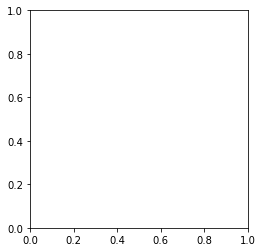

In [15]:
#checking the image having the lowest val
image = cv2.imread("./data/train/0/27481_right.jpeg")
plt.imshow(image);
plt.show()

In [16]:
to_delete = df["index"].head(3000).tolist()
remove_blur_images("./data/train/0/",to_delete)

#### Dropped blurred images from class 0

In [0]:
!ls tmp/train/0 | wc -l

22810


In [17]:
%time dict_sharp = blur_check("./data/train/1/")
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

Wall time: 4.12 s


In [18]:
df.head(100).tail()

,index,val
95,7886_left.jpeg,57.366545
96,25390_right.jpeg,57.429781
97,12577_right.jpeg,58.183764
98,10426_left.jpeg,58.477011
99,26433_right.jpeg,58.654780


In [19]:
to_delete = df["index"].head(100).tolist()
remove_blur_images("./data/train/1/",to_delete)

In [0]:
!ls tmp/train/1 | wc -l

2343


In [20]:
%time dict_sharp = blur_check("./data/train/2/")
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

Wall time: 9.26 s


In [21]:
df.head(250).tail()

,index,val
245,12111_right.jpeg,44.562877
246,21964_left.jpeg,44.585093
247,23121_left.jpeg,44.729716
248,42953_right.jpeg,44.770218
249,9011_left.jpeg,44.840402


In [22]:
to_delete = df["index"].head(250).tolist()
remove_blur_images("./data/train/2/",to_delete)

In [23]:
%time dict_sharp = blur_check("./data/train/3/")

Wall time: 1.85 s


In [24]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [25]:
df.head(40).tail()

,index,val
35,11196_right.jpeg,33.204158
36,23803_left.jpeg,34.654119
37,40341_right.jpeg,37.324810
38,21746_right.jpeg,37.563384
39,30226_right.jpeg,42.184571


In [26]:
to_delete = df["index"].head(40).tolist()
remove_blur_images("./data/train/3/",to_delete)

In [27]:
%time dict_sharp = blur_check("./data/train/4/")

Wall time: 1.2 s


In [28]:
frame = pd.Series(dict_sharp)
df = pd.DataFrame(frame,columns=["val"])
df.sort_values(by='val',inplace=True)
df.reset_index(level=0, inplace=True)

In [29]:
df.head(30)

,index,val
0,30723_left.jpeg,5.013091
1,40178_left.jpeg,7.339136
2,30675_left.jpeg,11.905828
3,31659_right.jpeg,13.496241
4,21788_right.jpeg,13.531731
5,24472_right.jpeg,14.615163
6,5258_right.jpeg,15.521148
7,21788_left.jpeg,16.233466
8,17411_right.jpeg,16.593806
9,5258_left.jpeg,16.656767


In [30]:
to_delete = df["index"].head(30).tolist()
remove_blur_images("./data/train/4/",to_delete)

In [0]:
!ls tmp/train/0 | wc -l

22810


In [0]:
!ls tmp/train/1 | wc -l

2343


In [0]:
!ls tmp/train/2 | wc -l

5042


In [0]:
!ls tmp/train/3 | wc -l

833


In [0]:
!ls tmp/train/4 | wc -l

678


### Data imbalance problem is there, which will affect classification
![title](imjup/data_dist.jpeg)

In [35]:
remove_excess_images("data/train/0/",14000)

In [0]:
!ls tmp/train/0 | wc -l

8810


### Data Distribution after removing excess images which can be taken as undersampling as well based on the defined criteria above

![title](imjup/data_dist_1.jpeg)

In [31]:
data_aug_val_1("data/train/1/")

In [32]:
data_aug_val("data/train/3/")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'tmp/train/4/'

In [33]:
data_aug_val("data/train/4/")

### Data Distribution after augmentation
![title](imjup/data_dist_2.jpeg)

#### Data imbalance has been considerably reduced now

In [ ]:
#creating a zip file containing all the train images
#using capture to mute the outputs
%%capture
!zip -r tmp/train{.zip,}

### Saving Images in google Drive

In [0]:
#uploading the zip created

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Save Keras Model or weights on google drive

# create on Colab directory
  
model_file = drive.CreateFile({'title' : 'train.zip'})
model_file.SetContentFile('./tmp/train.zip')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '12pmf7HcIoXtDNw7jXwUnqv6eXAG-zkjA'})